In [ ]:

import kagglehub
bhanupratapbiswas_inventory_analysis_case_study_path = kagglehub.dataset_download('bhanupratapbiswas/inventory-analysis-case-study')




100%|██████████| 61.9M/61.9M [00:00<00:00, 67.4MB/s]

Extracting files...


Data source import complete.


![Recommended Stock Breakdown.jpeg](attachment:dd50f27b-b6ea-4bf8-83d5-f95dfd68758b.jpeg)

# Calculating Recommended Stock

This notebook is a demonstration of how to calculate recommended stock.

It uses data from a fictional beverage distribution center.

* [Step 0: Load, clean, and wrangle data](#Step-0)
* [Step 1: Initial observations](#Step-1)
* [Step 2: ABC analysis](#Step-2)
* [Step 3: XYZ analysis](#Step-3)
* [Step 4: Calculate safety stock](#Step-4)
* [Step 5: Calculate Economic Order Quantity (optimal stock)](#Step-5)
* [Step 6: Calculate recommended stock](#Step-6)
* [Step 7: Final observations](#Step-7)


<a id="Step-0" ></a>
# Step 0: Load, clean, and wrangle data

## Load data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

invoice_purchases = pd.read_csv('InvoicePurchases12312016.csv',dtype = {'VendorNumber': str,'PONumber':str,},parse_dates=['InvoiceDate','PODate','PayDate'])
end_inv = pd.read_csv('EndInvFINAL12312016.csv',dtype={'Store':str,'Brand':str},parse_dates=['endDate'])
sales = pd.read_csv('SalesFINAL12312016.csv',dtype={'Store':str,'Brand':str,'VendorNo':str,'Classification':str},parse_dates=['SalesDate'])
beg_inv = pd.read_csv('BegInvFINAL12312016.csv', dtype={'Store':str,'Brand':str},parse_dates=['startDate'])
purchase_prices = pd.read_csv('2017PurchasePricesDec.csv',dtype={'Brand':str,'Classification':str,'VendorNumber':str})
purchases = pd.read_csv('PurchasesFINAL12312016.csv',dtype={'Store':str,'Brand':str,'VendorNumber':str,'PONumber':str,'Classification':str},parse_dates=['PODate','ReceivingDate','InvoiceDate','PayDate'])

In [ ]:
head=invoice_purchases.head(5)
print(head)

  VendorNumber                   VendorName InvoiceDate PONumber     PODate  \
0          105  ALTAMAR BRANDS LLC           2016-01-04     8124 2015-12-21   
1         4466  AMERICAN VINTAGE BEVERAGE    2016-01-07     8137 2015-12-22   
2          388  ATLANTIC IMPORTING COMPANY   2016-01-09     8169 2015-12-24   
3          480  BACARDI USA INC              2016-01-12     8106 2015-12-20   
4          516  BANFI PRODUCTS CORP          2016-01-07     8170 2015-12-24   

     PayDate  Quantity    Dollars  Freight Approval  
0 2016-02-16         6     214.26     3.47      NaN  
1 2016-02-21        15     140.55     8.57      NaN  
2 2016-02-16         5     106.60     4.61      NaN  
3 2016-02-05     10100  137483.78  2935.20      NaN  
4 2016-02-12      1935   15527.25   429.20      NaN  


In [ ]:
head1=purchases.head(10)
print(head1)

           InventoryId Store Brand                   Description   Size  \
0    69_MOUNTMEND_8412    69  8412     Tequila Ocho Plata Fresno  750mL   
1     30_CULCHETH_5255    30  5255  TGI Fridays Ultimte Mudslide  1.75L   
2    34_PITMERDEN_5215    34  5215  TGI Fridays Long Island Iced  1.75L   
3  1_HARDERSFIELD_5255     1  5255  TGI Fridays Ultimte Mudslide  1.75L   
4    76_DONCASTER_2034    76  2034     Glendalough Double Barrel  750mL   
5        5_SUTTON_3348     5  3348           Bombay Sapphire Gin  1.75L   
6  1_HARDERSFIELD_8358     1  8358             Bacardi 151 Proof  750mL   
7     30_CULCHETH_4903    30  4903          Bacardi Superior Rum  200mL   
8    34_PITMERDEN_3782    34  3782    Grey Goose Le Citron Vodka  750mL   
9  1_HARDERSFIELD_4233     1  4233     Castillo Silver Label Rum  1.75L   

  VendorNumber                   VendorName PONumber     PODate ReceivingDate  \
0          105  ALTAMAR BRANDS LLC              8124 2015-12-21    2016-01-02   
1         44

## Clean data

In [ ]:
purchase_prices.replace('Unknown', np.nan, inplace=True)
purchase_prices.Volume = purchase_prices.Volume.astype('float64')

In [ ]:
end_inv.City = end_inv.City.fillna('TYWARDREATH')
end_inv.InventoryId = end_inv.InventoryId.str.replace('__','_TYWARDREATH_')

## Wrangle data
Create total stock dataset by combining data from initial inventory and purchases.

In [ ]:
##Optional: limit purchases to first two months to match available sales data.
#purchases = purchases.loc[purchases.ReceivingDate<'2016-03-01']

In [ ]:
total_stock1 = beg_inv[['Brand','onHand','Price']]
total_stock1.columns = ['Brand','Quantity','Price']
total_stock1 = total_stock1.groupby(['Brand','Price']).sum().reset_index()
purchases_with_prices = pd.merge(purchases,purchase_prices[['Brand','Price']],on='Brand',how='left')
total_stock2 = purchases_with_prices[['Brand','Quantity','Price']]
total_stock2 = total_stock2.groupby(['Brand','Price']).sum().reset_index()
total_stock = pd.concat([total_stock1, total_stock2]).reset_index(drop=True)
total_stock

,Brand,Price,Quantity
0,100,159.99,33
1,1000,14.99,47
2,1001,5.99,1175
3,10011,5.99,7
4,10021,11.99,192
...,...,...,...
18753,994,21.99,136
18754,995,21.99,202
18755,996,299.99,27
18756,998,24.99,729


Update each inventory item's price to be the average of prices it actually has sold for. If never sold, keep listed price as-is.

In [ ]:
sales_avg_price = sales[['Brand','SalesQuantity','SalesDollars']].groupby(['Brand']).sum().reset_index()
sales_avg_price['avg_price'] = sales_avg_price.SalesDollars.div(sales_avg_price.SalesQuantity)

In [ ]:
total_stock_sold_prices = pd.merge(total_stock, sales_avg_price[['Brand','avg_price']], on='Brand',how='left')
total_stock_sold_prices.avg_price = total_stock_sold_prices.avg_price.fillna(total_stock_sold_prices.Price)
total_stock_sold_prices = total_stock_sold_prices.drop('Price',axis=1)
total_stock_sold_prices = total_stock_sold_prices.groupby(['Brand','avg_price']).sum().reset_index()
total_stock_sold_prices = total_stock_sold_prices.groupby('Brand').agg({'avg_price':'min','Quantity':'sum'}).reset_index()
total_stock_sold_prices.head()

,Brand,avg_price,Quantity
0,100,159.990000,183
1,1000,16.679655,62
2,10009,5.990000,48
3,1001,5.990000,8352
4,10010,5.990000,24


Create total sales dataset

In [ ]:
total_sales_by_brand = sales.groupby('Brand').agg(total_value =('SalesDollars','sum'),Quantity = ('SalesQuantity','sum')).reset_index()
total_sales_by_brand['avg_price'] = total_sales_by_brand.total_value.div(total_sales_by_brand.Quantity)
total_sales_by_brand.head()

,Brand,total_value,Quantity,avg_price
0,100,1119.93,7,159.990000
1,1000,483.71,29,16.679655
2,1001,5109.47,853,5.990000
3,10021,968.21,79,12.255823
4,1003,403.82,18,22.434444


Create total profit dataset by subtracting purchase price from sale price.

In [ ]:
paid_by_brand = purchases_with_prices.groupby('Brand').agg(Quantity=('Quantity','sum'),total_paid = ('Dollars','sum')).reset_index()
paid_by_brand['avg_paid'] = paid_by_brand.total_paid.div(paid_by_brand.Quantity)
paid_by_brand.head()

,Brand,Quantity,total_paid,avg_paid
0,100,150,18043.50,120.29
1,1000,15,174.30,11.62
2,10009,48,198.24,4.13
3,1001,7177,30717.56,4.28
4,10010,24,92.64,3.86


About 500 brands were sold that don't have a recorded purchase price.

Rather than mark them as 100% profit, I estimate a probable purchase price from the mean of all known markups, around 53%.

In [ ]:
total_profit_by_brand = pd.merge(total_sales_by_brand,paid_by_brand[['Brand','avg_paid']],on='Brand',how='left')
total_profit_by_brand['avg_markup'] = total_profit_by_brand.avg_price.div(total_profit_by_brand.avg_paid).sub(1)
total_profit_by_brand.avg_paid = total_profit_by_brand.avg_paid.fillna(total_profit_by_brand.avg_price.mul(1-total_profit_by_brand.avg_markup.mean()))
total_profit_by_brand['avg_profit'] = total_profit_by_brand.avg_price.sub(total_profit_by_brand.avg_paid)
total_profit_by_brand['total_value'] = total_profit_by_brand.Quantity.mul(total_profit_by_brand.avg_profit)
total_profit_by_brand.head()

,Brand,total_value,Quantity,avg_price,avg_paid,avg_markup,avg_profit
0,100,277.90,7,159.990000,120.29,0.330036,39.700000
1,1000,146.73,29,16.679655,11.62,0.435426,5.059655
2,1001,1458.63,853,5.990000,4.28,0.399533,1.710000
3,10021,344.90,79,12.255823,7.89,0.553336,4.365823
4,1003,103.94,18,22.434444,16.66,0.346605,5.774444


<a id="Step-1" ></a>
# Step 1: Initial observations

In [ ]:
print(f'Total SKUs: {len(total_stock_sold_prices):,}')
print(f'Total current stock: {end_inv.onHand.sum():,}')
print(f'Total items sold (two months): {total_profit_by_brand.Quantity.sum():,}')
print(f'Total revenue: ${total_sales_by_brand.total_value.sum():,.2f}')
print(f'Total profit: ${total_profit_by_brand.total_value.sum():,.2f}')
print(f'Items were sold for prices between ${sales.SalesPrice.min():,.2f} and ${sales.SalesPrice.max():,.2f}')

Total SKUs: 11,485
Total current stock: 4,885,776
Total items sold (two months): 2,451,169
Total revenue: $33,139,375.29
Total profit: $10,862,425.70
Items were sold for prices between $0.49 and $4,999.99


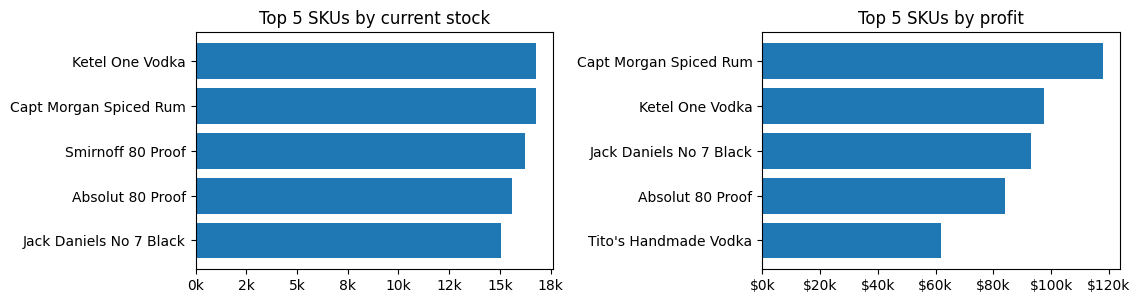

In [ ]:
top_5_stocked = end_inv.groupby('Brand').agg(Description = ('Description','first'), current_stock = ('onHand','sum')).sort_values('current_stock',ascending=False).reset_index().head()
top_5_stocked = top_5_stocked.sort_values('current_stock',ascending=True)
top_5_profit = total_profit_by_brand.sort_values('total_value',ascending=False).head()[['Brand','total_value']].reset_index(drop=True)
top_5_profit = pd.merge(top_5_profit,sales[['Brand','Description']].drop_duplicates(),on='Brand',how='left')
top_5_profit = top_5_profit.sort_values('total_value',ascending=True)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(13, 6)
fig.tight_layout(pad=12)

ax1.barh(top_5_stocked.Description,top_5_stocked.current_stock)
ax1.xaxis.set_major_formatter('{x:,.0f}')
ax1.set_title('Top 5 SKUs by current stock')
ticks = ax1.get_xticks()
xlabels = [f'{x/1000:,.0f}k' for x in ticks]
ax1.xaxis.set_ticks(ticks[:-1])
ax1.set_xticklabels(xlabels[:-1])

ax2.barh(top_5_profit.Description,top_5_profit.total_value)
ticks = ax2.get_xticks()
xlabels = [f'${x/1000:,.0f}k' for x in ticks]
ax2.xaxis.set_ticks(ticks[:-1])
ax2.set_xticklabels(xlabels[:-1])
ax2.set_title('Top 5 SKUs by profit')
plt.show()

<a id="Step-2" ></a>
# Step 2: ABC analysis

ABC analysis is used to divide SKUs into high, medium, and low value to the company.

It can be calculated from total stock, total revenue, or total profit.

I've chosen to use total profit.

In [ ]:
##Use total stock to determine ABC
#df = total_stock_sold_prices
#df['total_value'] = df.avg_price*df.Quantity

##Use revenue to determine ABC
#df = total_sales_by_brand

##Use profit from sales to determine ABC
df = total_profit_by_brand

Add SKUs to dataset that don't appear in sales dataset, if necessary.

In [ ]:
if df.Brand.nunique() < total_stock_sold_prices.Brand.nunique():
    df = pd.merge(total_stock_sold_prices[['Brand','avg_price']],df,on='Brand',how='left').reset_index(drop=True)
    df.total_value = df.total_value.fillna(0)
    df.Quantity = df.Quantity.fillna(0)
    df.avg_price_y = df.avg_price_y.fillna(df.avg_price_x)
    df = df.drop('avg_price_x',axis=1)
    df=df.rename(columns={'avg_price_y':'avg_price'})
df

,Brand,total_value,Quantity,avg_price,avg_paid,avg_markup,avg_profit
0,100,277.90,7.0,159.990000,120.29,0.330036,39.700000
1,1000,146.73,29.0,16.679655,11.62,0.435426,5.059655
2,10009,0.00,0.0,5.990000,NaN,NaN,NaN
3,1001,1458.63,853.0,5.990000,4.28,0.399533,1.710000
4,10010,0.00,0.0,5.990000,NaN,NaN,NaN
...,...,...,...,...,...,...,...
11480,994,201.04,28.0,21.990000,14.81,0.484808,7.180000
11481,995,142.00,24.0,21.906667,15.99,0.370023,5.916667
11482,996,0.00,0.0,299.990000,NaN,NaN,NaN
11483,998,242.60,20.0,30.640000,18.51,0.655321,12.130000


Add current stock.

In [ ]:
current_stock_df = end_inv.groupby('Brand').agg(current_stock = ('onHand','sum')).reset_index()
df = pd.merge(df,current_stock_df,on='Brand',how='left')
df.current_stock = df.current_stock.fillna(0)
df.head()

,Brand,total_value,Quantity,avg_price,avg_paid,avg_markup,avg_profit,current_stock
0,100,277.90,7.0,159.990000,120.29,0.330036,39.700000,59.0
1,1000,146.73,29.0,16.679655,11.62,0.435426,5.059655,0.0
2,10009,0.00,0.0,5.990000,NaN,NaN,NaN,13.0
3,1001,1458.63,853.0,5.990000,4.28,0.399533,1.710000,425.0
4,10010,0.00,0.0,5.990000,NaN,NaN,NaN,18.0


Here I define "A" (high value) as the most valuable SKUs that make up 80% of the company's profit, "B" as the next 15%, and "C" as the final 5%.

These numbers could be tweaked.

In [ ]:
def ABC(perc):
    if perc > 0 and perc < 0.8:
        return 'A'
    elif perc >= 0.8 and perc < 0.95:
        return 'B'
    elif perc >= 0.95:
        return 'C'

In [ ]:
df=df.sort_values('total_value',ascending=False)
df['running_cumulative_value'] = df['total_value'].cumsum()
df['total_total_value'] = df['total_value'].sum()
df['running_perc'] =  df['running_cumulative_value']/df['total_total_value']
df['abc_class'] = df['running_perc'].apply(ABC)
df = df.drop(['running_cumulative_value','total_total_value','running_perc'],axis=1).reset_index(drop=True)
df

,Brand,total_value,Quantity,avg_price,avg_paid,avg_markup,avg_profit,current_stock,abc_class
0,4261,1.177563e+05,20226.0,21.992027,16.17,3.600511e-01,5.822027e+00,16769.0,A
1,3545,9.764030e+04,11883.0,30.106806,21.89,3.753680e-01,8.216806e+00,16770.0,A
2,1233,9.309816e+04,9578.0,35.990000,26.27,3.700038e-01,9.720000e+00,15047.0,A
3,8068,8.404775e+04,11189.0,25.751641,18.24,4.118224e-01,7.511641e+00,15608.0,A
4,3405,6.174540e+04,9203.0,29.899269,23.19,2.893173e-01,6.709269e+00,12268.0,A
...,...,...,...,...,...,...,...,...,...
11480,2204,0.000000e+00,0.0,429.990000,NaN,NaN,NaN,79.0,C
11481,3931,0.000000e+00,0.0,0.990000,NaN,NaN,NaN,65.0,C
11482,26348,0.000000e+00,0.0,69.990000,NaN,NaN,NaN,38.0,C
11483,17404,0.000000e+00,0.0,899.990000,NaN,NaN,NaN,10.0,C


Display relative proportions of A, B, and C class inventory.

In [ ]:
df_by_class = df.groupby('abc_class').agg(
    SKUs = ('abc_class','count'),
    Quantity_sold = ('Quantity','sum'),
    total_profit = ('total_value', 'sum'),
    current_stock = ('current_stock','sum')).reset_index()
df_by_class['perc_quantity'] = df_by_class.Quantity_sold.div(df_by_class.Quantity_sold.sum()).round(2)
df_by_class['perc_profit'] = df_by_class.total_profit.div(df_by_class.total_profit.sum()).round(2)
df_by_class['perc_SKUs'] = df_by_class.SKUs.div(df_by_class.SKUs.sum()).round(2)
df_by_class['perc_current_stock'] = df_by_class.current_stock.div(df_by_class.current_stock.sum()).round(2)
df_by_class.total_profit = df_by_class.total_profit.apply(lambda x: "${:,.2f}".format(x))
df_by_class

,abc_class,SKUs,Quantity_sold,total_profit,current_stock,perc_quantity,perc_profit,perc_SKUs,perc_current_stock
0,A,1532,1852112.0,"$8,688,772.54",2887033.0,0.76,0.80,0.13,0.59
1,B,1836,454468.0,"$1,630,395.83",1008831.0,0.19,0.15,0.16,0.21
2,C,8117,144589.0,"$543,257.33",989912.0,0.06,0.05,0.71,0.20


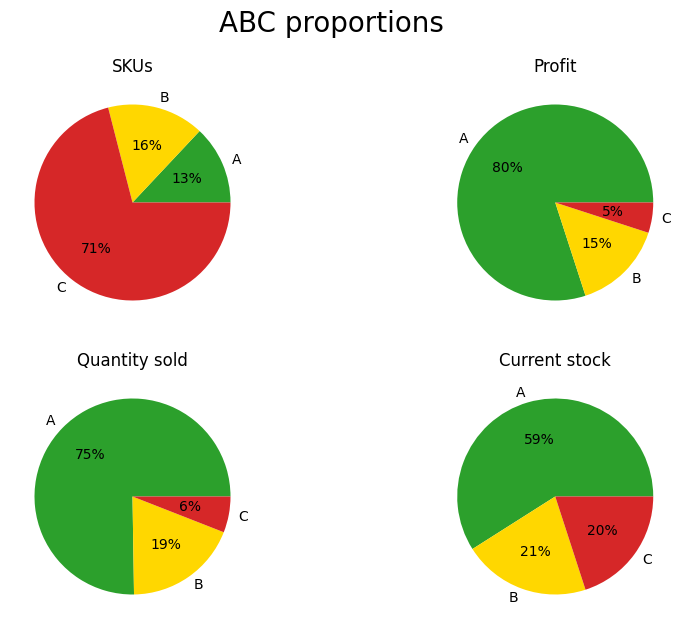

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(10, 7)
ax1.pie(df_by_class.perc_SKUs,labels=df_by_class.abc_class,autopct='%.0f%%',colors=['tab:green','gold','tab:red'])
ax1.set_title('SKUs')
ax2.pie(df_by_class.perc_profit,labels=df_by_class.abc_class,autopct='%.0f%%',colors=['tab:green','gold','tab:red'])
ax2.set_title('Profit')
ax3.pie(df_by_class.perc_quantity,labels=df_by_class.abc_class,autopct='%.0f%%',colors=['tab:green','gold','tab:red'])
ax3.set_title('Quantity sold')
ax4.pie(df_by_class.perc_current_stock,labels=df_by_class.abc_class,autopct='%.0f%%',colors=['tab:green','gold','tab:red'])
ax4.set_title('Current stock')
fig.suptitle('ABC proportions', fontsize=20)
plt.show()

Notably, A class items form the great majority of quantity sold, while representing only 13% of all SKUs. C class is the opposite, at 71% of SKUs but only 6% of quantity sold. While it is typical for C class SKUs to outnumber A class SKUs, this is a bit extreme. This company should investigate if it can cut some of its C class offerings and/or expand its A class.

<a id="Step-3" ></a>
# Step 3: XYZ analysis

ABC analysis is powerful, but it becomes more helpful when combined with XYZ analysis, which categorizes inventory into high, medium, and low demand predictability.

I will calculate predictability based on the covariance of sale quantities.

The first step is to list how much quantity of each SKU was sold each day, even if it was zero. (Ideally this would account for when a SKU is sold out, but I'll leave that for a future project.)

In [ ]:
simp_sales = sales[['Brand','SalesDate','SalesQuantity']].groupby(['SalesDate','Brand']).sum().reset_index()
dates = pd.merge(sales.Brand.drop_duplicates(),sales.SalesDate.drop_duplicates(),how='cross').sort_values(['Brand','SalesDate'])
full_sales = pd.merge(dates,simp_sales, on=['Brand','SalesDate'],how='left').fillna(0)
full_sales.head()

,Brand,SalesDate,SalesQuantity
0,100,2016-01-01,0.0
1,100,2016-01-02,1.0
2,100,2016-01-03,0.0
3,100,2016-01-04,0.0
4,100,2016-01-05,0.0


Calculate covariance by dividing the sale quantity's standard deviation by its mean.

In [ ]:
sales_agg = full_sales.groupby('Brand').agg(
    sales_mean = ('SalesQuantity','mean'),
    sales_std = ('SalesQuantity','std'),
).reset_index()
sales_agg['sales_cov'] = sales_agg.sales_std.div(sales_agg.sales_mean)
sales_agg.sort_values('sales_cov')

,Brand,sales_mean,sales_std,sales_cov
5080,3687,28.666667,15.942340,0.556128
324,12213,22.516667,13.420818,0.596039
327,12220,34.250000,21.530920,0.628640
3919,26463,20.166667,13.267990,0.657917
5944,4359,19.183333,12.829378,0.668777
...,...,...,...,...
6053,44338,0.200000,1.549193,7.745967
4980,36197,0.300000,2.323790,7.745967
1547,18645,0.100000,0.774597,7.745967
6219,45875,0.083333,0.645497,7.745967


Here I define demand predictability based on which of three quantiles a SKU's covariance is located.

This ensures X, Y, and Z will be equally distributed among SKUs that have been sold at least three times.

In reality, X, Y, and Z are not likely to be equally represented and should be calculated based on predetermined thresholds.

In [ ]:
X_threshold = sales_agg.sales_cov.quantile([.33333,.66666])[0.33333]
Y_threshold = sales_agg.sales_cov.quantile([.33333,.66666])[0.66666]

In [ ]:
def XYZ(cov):
    if cov < X_threshold:
        return 'X'
    elif cov >= X_threshold and cov < Y_threshold:
        return 'Y'
    elif cov >= Y_threshold:
        return 'Z'

In [ ]:
sales_agg['xyz_class']=sales_agg.sales_cov.apply(XYZ)
sales_agg

,Brand,sales_mean,sales_std,sales_cov,xyz_class
0,100,0.116667,0.323732,2.774844,Y
1,1000,0.483333,1.171580,2.423958,Y
2,1001,14.216667,47.433483,3.336470,Y
3,10021,1.316667,1.961422,1.489687,X
4,1003,0.300000,1.464842,4.882807,Z
...,...,...,...,...,...
7653,993,0.033333,0.181020,5.430610,Z
7654,994,0.466667,1.032796,2.213133,Y
7655,995,0.400000,0.668923,1.672307,Y
7656,998,0.333333,0.680644,2.041933,Y


Combine with profit dataset and mark each SKU without at least three sales as "Z".

In [ ]:
abc_xyz_df = pd.merge(df,sales_agg[['Brand','xyz_class']],on='Brand',how='left')
abc_xyz_df.xyz_class = abc_xyz_df.xyz_class.fillna('Z')
abc_xyz_df.head()

,Brand,total_value,Quantity,avg_price,avg_paid,avg_markup,avg_profit,current_stock,abc_class,xyz_class
0,4261,117756.32,20226.0,21.992027,16.17,0.360051,5.822027,16769.0,A,X
1,3545,97640.30,11883.0,30.106806,21.89,0.375368,8.216806,16770.0,A,X
2,1233,93098.16,9578.0,35.990000,26.27,0.370004,9.720000,15047.0,A,X
3,8068,84047.75,11189.0,25.751641,18.24,0.411822,7.511641,15608.0,A,X
4,3405,61745.40,9203.0,29.899269,23.19,0.289317,6.709269,12268.0,A,X


Display relative proportions of X, Y, and Z class inventory.

In [ ]:
df_by_class = abc_xyz_df.groupby('xyz_class').agg(
    SKUs = ('xyz_class','count'),
    Quantity_sold = ('Quantity','sum'),
    total_profit = ('total_value', 'sum'),
    current_stock = ('current_stock','sum')).reset_index()
df_by_class['perc_quantity'] = df_by_class.Quantity_sold.div(df_by_class.Quantity_sold.sum()).round(2)
df_by_class['perc_profit'] = df_by_class.total_profit.div(df_by_class.total_profit.sum()).round(2)
df_by_class['perc_SKUs'] = df_by_class.SKUs.div(df_by_class.SKUs.sum()).round(2)
df_by_class['perc_current_stock'] = df_by_class.current_stock.div(df_by_class.current_stock.sum()).round(2)
df_by_class.total_profit = df_by_class.total_profit.apply(lambda x: "${:,.2f}".format(x))
df_by_class

,xyz_class,SKUs,Quantity_sold,total_profit,current_stock,perc_quantity,perc_profit,perc_SKUs,perc_current_stock
0,X,2553,2185063.0,"$9,122,325.27",3512711.0,0.89,0.84,0.22,0.72
1,Y,2540,236251.0,"$1,455,537.50",703658.0,0.10,0.13,0.22,0.14
2,Z,6392,29855.0,"$284,562.94",669407.0,0.01,0.03,0.56,0.14


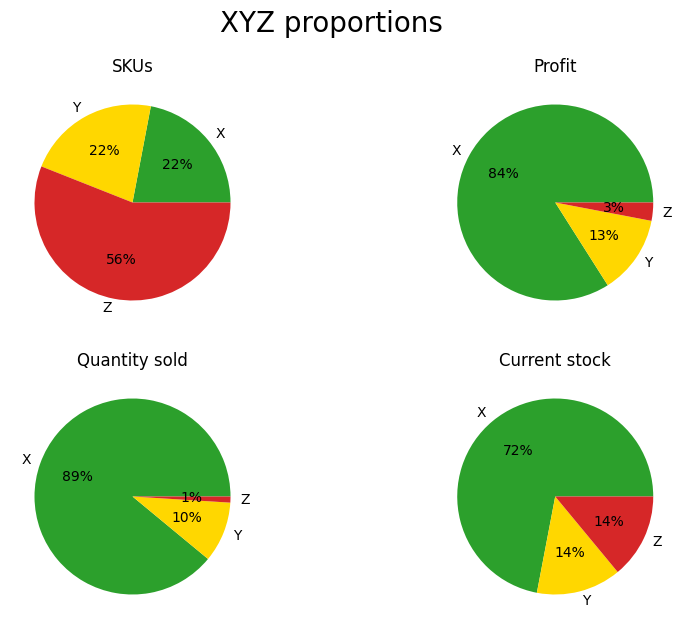

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(10, 7)
ax1.pie(df_by_class.perc_SKUs,labels=df_by_class.xyz_class,autopct='%.0f%%',colors=['tab:green','gold','tab:red'])
ax1.set_title('SKUs')
ax2.pie(df_by_class.perc_profit,labels=df_by_class.xyz_class,autopct='%.0f%%',colors=['tab:green','gold','tab:red'])
ax2.set_title('Profit')
ax3.pie(df_by_class.perc_quantity,labels=df_by_class.xyz_class,autopct='%.0f%%',colors=['tab:green','gold','tab:red'])
ax3.set_title('Quantity sold')
ax4.pie(df_by_class.perc_current_stock,labels=df_by_class.xyz_class,autopct='%.0f%%',colors=['tab:green','gold','tab:red'])
ax4.set_title('Current stock')
fig.suptitle('XYZ proportions', fontsize=20)
plt.show()

The great majority of sales and profit come from X class items, the most predictable class. This is healthy sign for the company, as it indicates less extreme highs and lows. Note that the current stock has a disproportionate amount of Z class stock. This may or may not be a bad thing, depending on the company's goals (customer satisfaction vs profit), but it should probably be reduced.

<a id="Step-4" ></a>
# Step 4: Calculate safety stock

Combine ABC and XYZ codes.

In [ ]:
abc_xyz_df['abc_xyz_class'] = abc_xyz_df.abc_class+abc_xyz_df.xyz_class
abc_xyz_df

,Brand,total_value,Quantity,avg_price,avg_paid,avg_markup,avg_profit,current_stock,abc_class,xyz_class,abc_xyz_class
0,4261,1.177563e+05,20226.0,21.992027,16.17,3.600511e-01,5.822027e+00,16769.0,A,X,AX
1,3545,9.764030e+04,11883.0,30.106806,21.89,3.753680e-01,8.216806e+00,16770.0,A,X,AX
2,1233,9.309816e+04,9578.0,35.990000,26.27,3.700038e-01,9.720000e+00,15047.0,A,X,AX
3,8068,8.404775e+04,11189.0,25.751641,18.24,4.118224e-01,7.511641e+00,15608.0,A,X,AX
4,3405,6.174540e+04,9203.0,29.899269,23.19,2.893173e-01,6.709269e+00,12268.0,A,X,AX
...,...,...,...,...,...,...,...,...,...,...,...
11480,2204,0.000000e+00,0.0,429.990000,NaN,NaN,NaN,79.0,C,Z,CZ
11481,3931,0.000000e+00,0.0,0.990000,NaN,NaN,NaN,65.0,C,Z,CZ
11482,26348,0.000000e+00,0.0,69.990000,NaN,NaN,NaN,38.0,C,Z,CZ
11483,17404,0.000000e+00,0.0,899.990000,NaN,NaN,NaN,10.0,C,Z,CZ


Now that we have the ABC-XYZ code for each SKU, we can use it to help determine ideal safety stock.

How exactly this should be done will depend on the company's goals.

Here I've assigned higher service levels (that is, the desired probability of something being in stock on any given day) to SKUs with higher value and/or higher consistency, and lower service levels to those with lower values and/or consistency.

A higher service level means more safety stock.

In [ ]:
from scipy.stats import norm
service_levels = {'AX':.97, 'AY':.95, 'AZ':.93,'BX':.91,'BY':.90,'BZ':.89,'CX':.85,'CY':.80,'CZ':.70}
service_factors = {k: norm.ppf(v) for k, v in service_levels.items()}
abc_xyz_df['service_factor'] = abc_xyz_df.abc_xyz_class.map(service_factors)
abc_xyz_df

,Brand,total_value,Quantity,avg_price,avg_paid,avg_markup,avg_profit,current_stock,abc_class,xyz_class,abc_xyz_class,service_factor
0,4261,1.177563e+05,20226.0,21.992027,16.17,3.600511e-01,5.822027e+00,16769.0,A,X,AX,1.880794
1,3545,9.764030e+04,11883.0,30.106806,21.89,3.753680e-01,8.216806e+00,16770.0,A,X,AX,1.880794
2,1233,9.309816e+04,9578.0,35.990000,26.27,3.700038e-01,9.720000e+00,15047.0,A,X,AX,1.880794
3,8068,8.404775e+04,11189.0,25.751641,18.24,4.118224e-01,7.511641e+00,15608.0,A,X,AX,1.880794
4,3405,6.174540e+04,9203.0,29.899269,23.19,2.893173e-01,6.709269e+00,12268.0,A,X,AX,1.880794
...,...,...,...,...,...,...,...,...,...,...,...,...
11480,2204,0.000000e+00,0.0,429.990000,NaN,NaN,NaN,79.0,C,Z,CZ,0.524401
11481,3931,0.000000e+00,0.0,0.990000,NaN,NaN,NaN,65.0,C,Z,CZ,0.524401
11482,26348,0.000000e+00,0.0,69.990000,NaN,NaN,NaN,38.0,C,Z,CZ,0.524401
11483,17404,0.000000e+00,0.0,899.990000,NaN,NaN,NaN,10.0,C,Z,CZ,0.524401


Calculating safety stock also requires the mean and standard deviation of quantities sold, which have already been determined, and the mean and standard deviation of lead times (the time between ordering a SKU and receiving it).

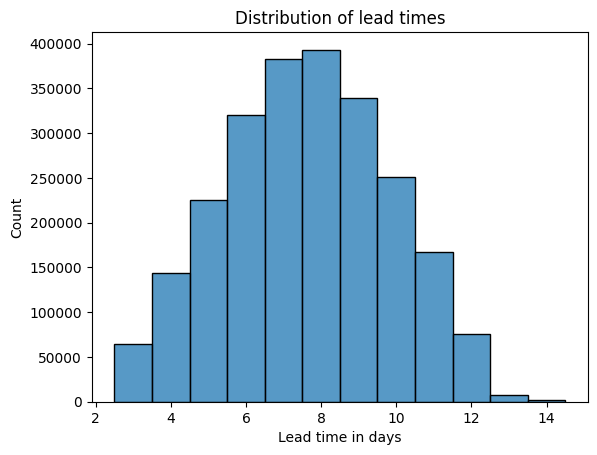

In [ ]:
purchases['lead_time'] = purchases.ReceivingDate-purchases.PODate
ax = sns.histplot(purchases.lead_time.dt.days,discrete=True)
ax.set(xlabel='Lead time in days', title='Distribution of lead times')
plt.show()

This chart shows the lead times have a normal distribution, which is important for the safety stock formula.

Calculate lead time mean and std.

In [ ]:
purchases_agg = purchases.groupby('Brand').agg(
    lead_time_mean = ('lead_time','mean'),
    lead_time_std = ('lead_time','std'),
).reset_index()
purchases_agg.head()

,Brand,lead_time_mean,lead_time_std
0,100,6 days 20:48:00,1 days 13:40:33.355677774
1,1000,9 days 06:00:00,2 days 12:00:00
2,10009,8 days 00:00:00,1 days 09:56:28.051789035
3,1001,7 days 06:48:46.451612903,2 days 02:42:34.603849582
4,10010,9 days 00:00:00,NaT


We now have everything to calculate the safety stock, treating demand and lead times as independent factors, using the following formula.
* SS = safety stock
* Z = service factor
* $\mu$ = mean
* $\sigma$ = standard deviation

## $$SS = Z \times \sqrt{\mu_{lead time} \times \sigma^2_{demand} + \mu_{demand} \times \sigma^2_{lead time}}$$

In [ ]:
rec_stock_df = pd.merge(abc_xyz_df, sales_agg[['Brand','sales_mean','sales_std']], on='Brand',how='left')
rec_stock_df = pd.merge(rec_stock_df, purchases_agg, on='Brand',how='left')

#Put lead time into decimal format
rec_stock_df.lead_time_mean = rec_stock_df.lead_time_mean.dt.days+rec_stock_df.lead_time_mean.dt.seconds/(60*60*24)
rec_stock_df.lead_time_std = rec_stock_df.lead_time_std.dt.days+rec_stock_df.lead_time_std.dt.seconds/(60*60*24)

#Implement safety stock formula
rec_stock_df['safety_stock'] = rec_stock_df.service_factor.mul(rec_stock_df.lead_time_mean.mul(rec_stock_df.sales_std.pow(2)).add(rec_stock_df.sales_mean.mul(rec_stock_df.lead_time_std.pow(2))).pow(0.5)).round()
rec_stock_df[['Brand','safety_stock']].head()

,Brand,safety_stock
0,4261,1757.0
1,3545,1161.0
2,1233,785.0
3,8068,888.0
4,3405,884.0


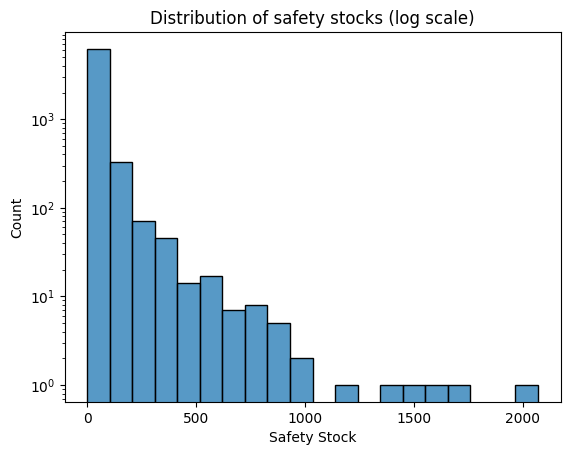

In [ ]:
ax = sns.histplot(rec_stock_df.safety_stock,bins=20)
ax.set(xlabel='Safety Stock', title='Distribution of safety stocks (log scale)')
ax.set_yscale('log')
plt.show()

As should be expected, only a few SKUs should have a high safety stock. This is will help keep inventory costs down.

<a id="Step-5" ></a>
# Step 5: Calculate Economic Order Quantity (optimal stock)

Economic Order Quantity (EOQ) is the balance point between avoiding the costs associated with frequent small orders and the avoiding the costs of holding inventory.

To find the EOQ, we must know the Order Placement Cost (OPC) of each SKU, which measures how much money it costs to place an additional order. We also must know the Stock Ownership Cost (SOC), which measures how much money it costs to hold an item in inventory.

These measurements are highly context-dependent, reliant upon information that is not available in this example dataset. Therefore I am here using the arbitrary guesses of $30 for OPC and 10% of an item's value for the annual SOC. (Ideally SOC would take into account the size of the item, but I'll leave that for another project.)

## $$EOQ = \sqrt{2D \times OPC \over SOC}$$

In [ ]:
OPC = 30 #Order Placement Cost, chosen arbitrarily
SOC = rec_stock_df.avg_price.mul(.1).div(365) #Stock Ownership Cost, ratio to average price chosen arbitarily
rec_stock_df['EOQ'] = rec_stock_df.sales_mean.mul(2).mul(OPC).div(SOC).pow(.5).round()
rec_stock_df[['Brand','safety_stock','EOQ']].head()

,Brand,safety_stock,EOQ
0,4261,1757.0,1832.0
1,3545,1161.0,1200.0
2,1233,785.0,986.0
3,8068,888.0,1259.0
4,3405,884.0,1060.0


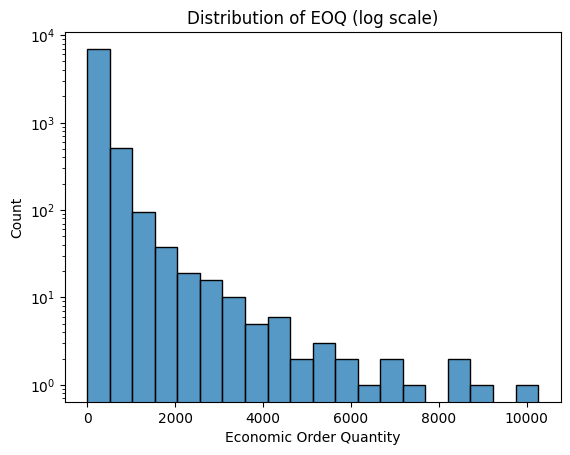

In [ ]:
ax = sns.histplot(rec_stock_df.EOQ,bins=20)
ax.set(xlabel='Economic Order Quantity', title='Distribution of EOQ (log scale)')
ax.set_yscale('log')
plt.show()

As with safety stock, only a few SKUs have large EOQs.

<a id="Step-6" ></a>
# Step 6: Calculate recommended stock

Add EOQ and safety stock together to create recommended stock.

In [ ]:
rec_stock_df['rec_stock'] = rec_stock_df.safety_stock.add(rec_stock_df.EOQ)
rec_stock_df.drop(rec_stock_df.columns[1:16],axis=1)

,Brand,safety_stock,EOQ,rec_stock
0,4261,1757.0,1832.0,3589.0
1,3545,1161.0,1200.0,2361.0
2,1233,785.0,986.0,1771.0
3,8068,888.0,1259.0,2147.0
4,3405,884.0,1060.0,1944.0
...,...,...,...,...
11480,2204,NaN,NaN,NaN
11481,3931,NaN,NaN,NaN
11482,26348,NaN,NaN,NaN
11483,17404,NaN,NaN,NaN


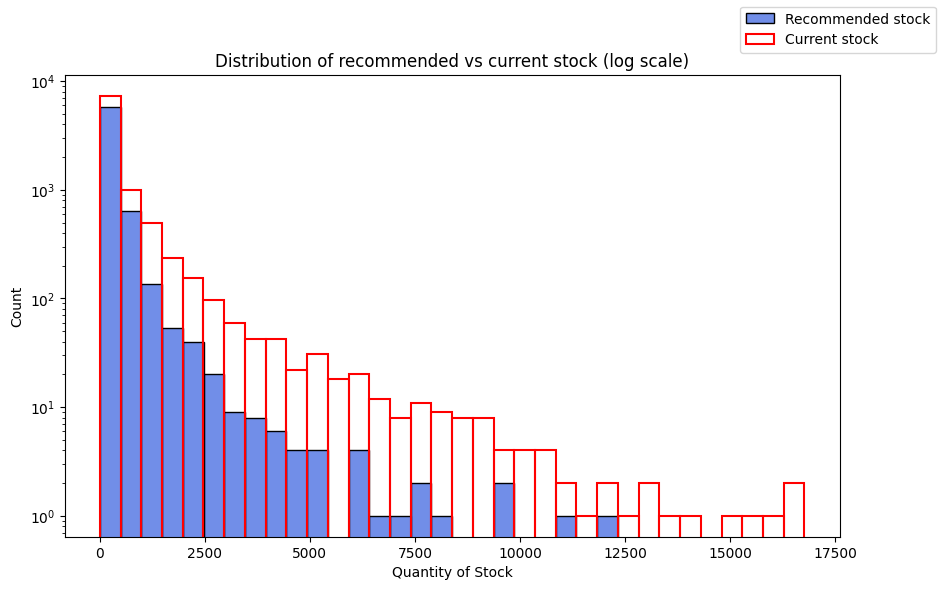

In [ ]:
current_stock_df = end_inv.groupby('Brand').agg(current_stock = ('onHand','sum')).reset_index()
fig = plt.figure(figsize=(10,6))
ax1 = sns.histplot(rec_stock_df.rec_stock,binwidth=500,color = 'royalblue')
ax2 = sns.histplot(current_stock_df.current_stock,fill=False,color='r',binwidth=500)
fig.legend(labels=['Recommended stock','Current stock'])
ax1.set_yscale('log')
ax2.set(xlabel='Quantity of Stock', title='Distribution of recommended vs current stock (log scale)')
ax2.set_yscale('log')
plt.show()

This chart doesn't tell the whole story, but it does indicate a significant overstocking of several SKUs. The degree is difficult to assess due to the log scale, and no conclusion can be drawn regarding possible understocking. More digging is needed.

<a id="Step-7" ></a>
# Step 7: Final observations

Now that we have the recommended stock for each SKU, we can subtract the current stock from it to find the gap.\
This will result in a clearer picture of the most overstocked and most understocked SKUs.

Calculate whether a SKU is over- or understocked, and by how much.\
I've set the threshold for being tagged as either at 10% of the recommended stock.\
I've also tagged SKUs that have stock but have been sold less than three times as overstocked.

In [ ]:
threshold = 0.1
needed_stock_df = rec_stock_df
needed_stock_df['understock_quantity'] = needed_stock_df.rec_stock.sub(needed_stock_df.current_stock).clip(lower=0)
needed_stock_df['overstock_quantity'] = needed_stock_df.current_stock.sub(needed_stock_df.rec_stock).clip(lower=0)
needed_stock_df['is_understocked'] = needed_stock_df.understock_quantity>needed_stock_df.rec_stock.mul(threshold)
needed_stock_df['is_overstocked'] = (needed_stock_df.overstock_quantity>needed_stock_df.rec_stock.mul(threshold)) | ((needed_stock_df.rec_stock.isna() & needed_stock_df.current_stock>0))
#Display
needed_stock_df[['Brand','current_stock','rec_stock','understock_quantity','overstock_quantity','is_understocked','is_overstocked']].sort_values('Brand').head()

,Brand,current_stock,rec_stock,understock_quantity,overstock_quantity,is_understocked,is_overstocked
3991,100,59.0,14.0,0.0,45.0,False,True
4840,1000,0.0,83.0,83.0,0.0,True,False
8763,10009,13.0,NaN,NaN,NaN,False,True
1663,1001,425.0,885.0,460.0,0.0,True,False
10096,10010,18.0,NaN,NaN,NaN,False,True


Having a full list of understocked and overstocked SKUs is useful, but just to get an idea of the worst discrepancies, I'll display the Top 10 for each.

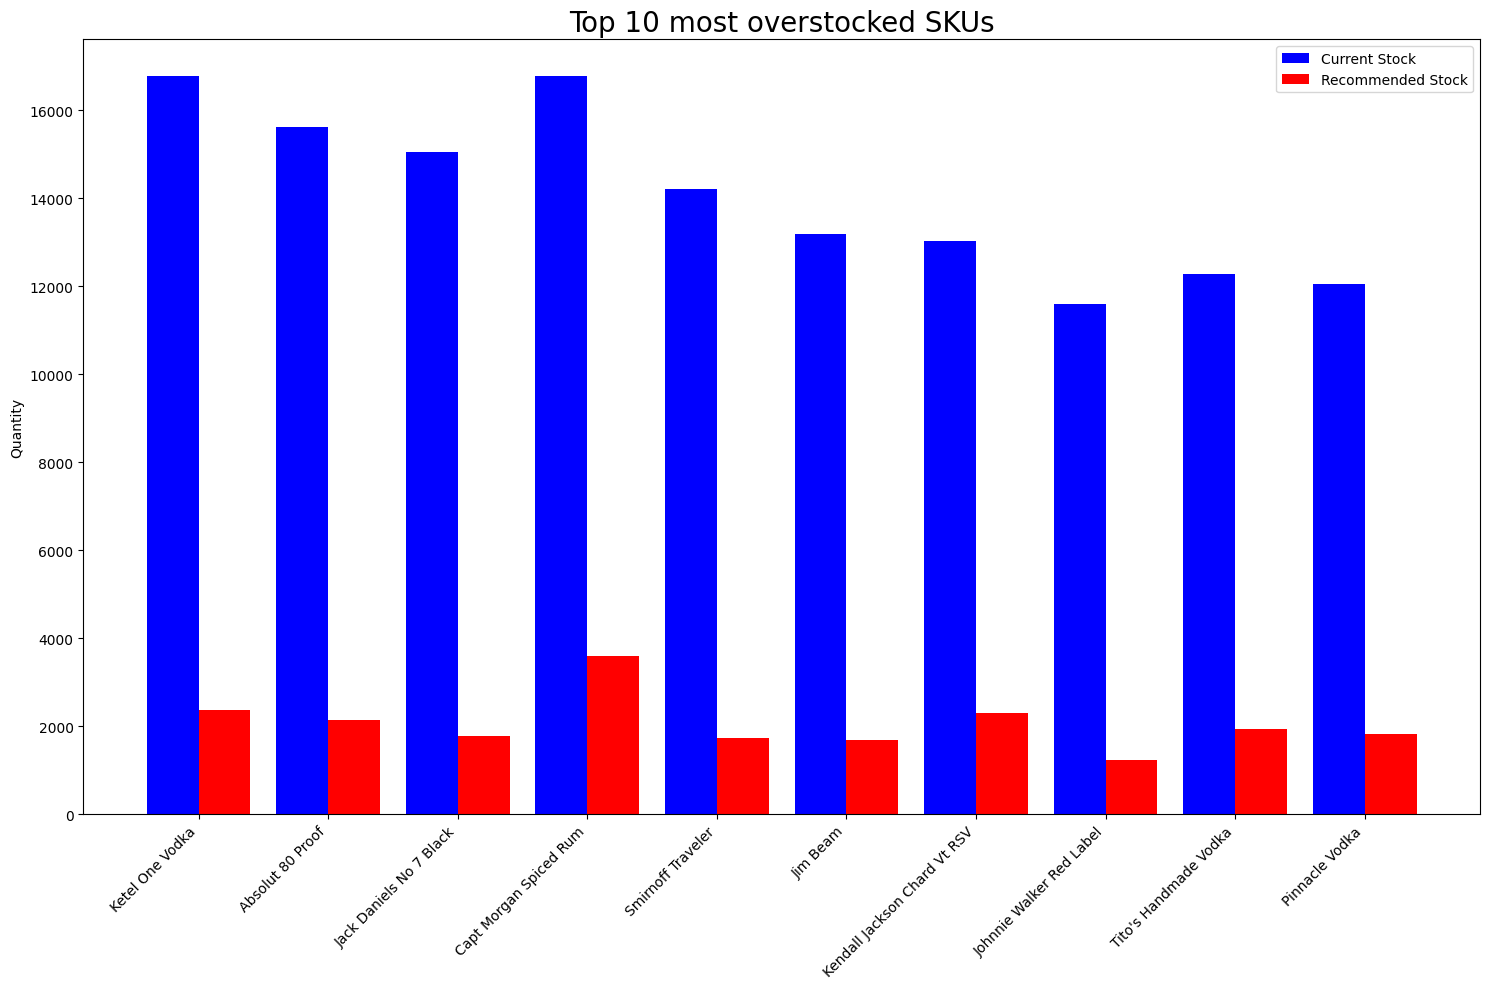

In [ ]:
top_10_overstocked = needed_stock_df.sort_values('overstock_quantity',ascending=False).head(10)
top_10_overstocked = pd.merge(top_10_overstocked,sales[['Brand','Description']].drop_duplicates(),on='Brand',how='left')

bar_width = 0.4
index = np.arange(len(top_10_overstocked))
plt.figure(figsize=(15, 10))
bar1 = plt.bar(index, top_10_overstocked['current_stock'], bar_width, label='Current Stock', color='b')
bar2 = plt.bar([i + bar_width for i in index], top_10_overstocked['rec_stock'], bar_width, label='Recommended Stock', color='r')
plt.ylabel('Quantity')
plt.title('Top 10 most overstocked SKUs',fontsize=20)
plt.xticks([i + bar_width / 2 for i in index], top_10_overstocked['Description'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

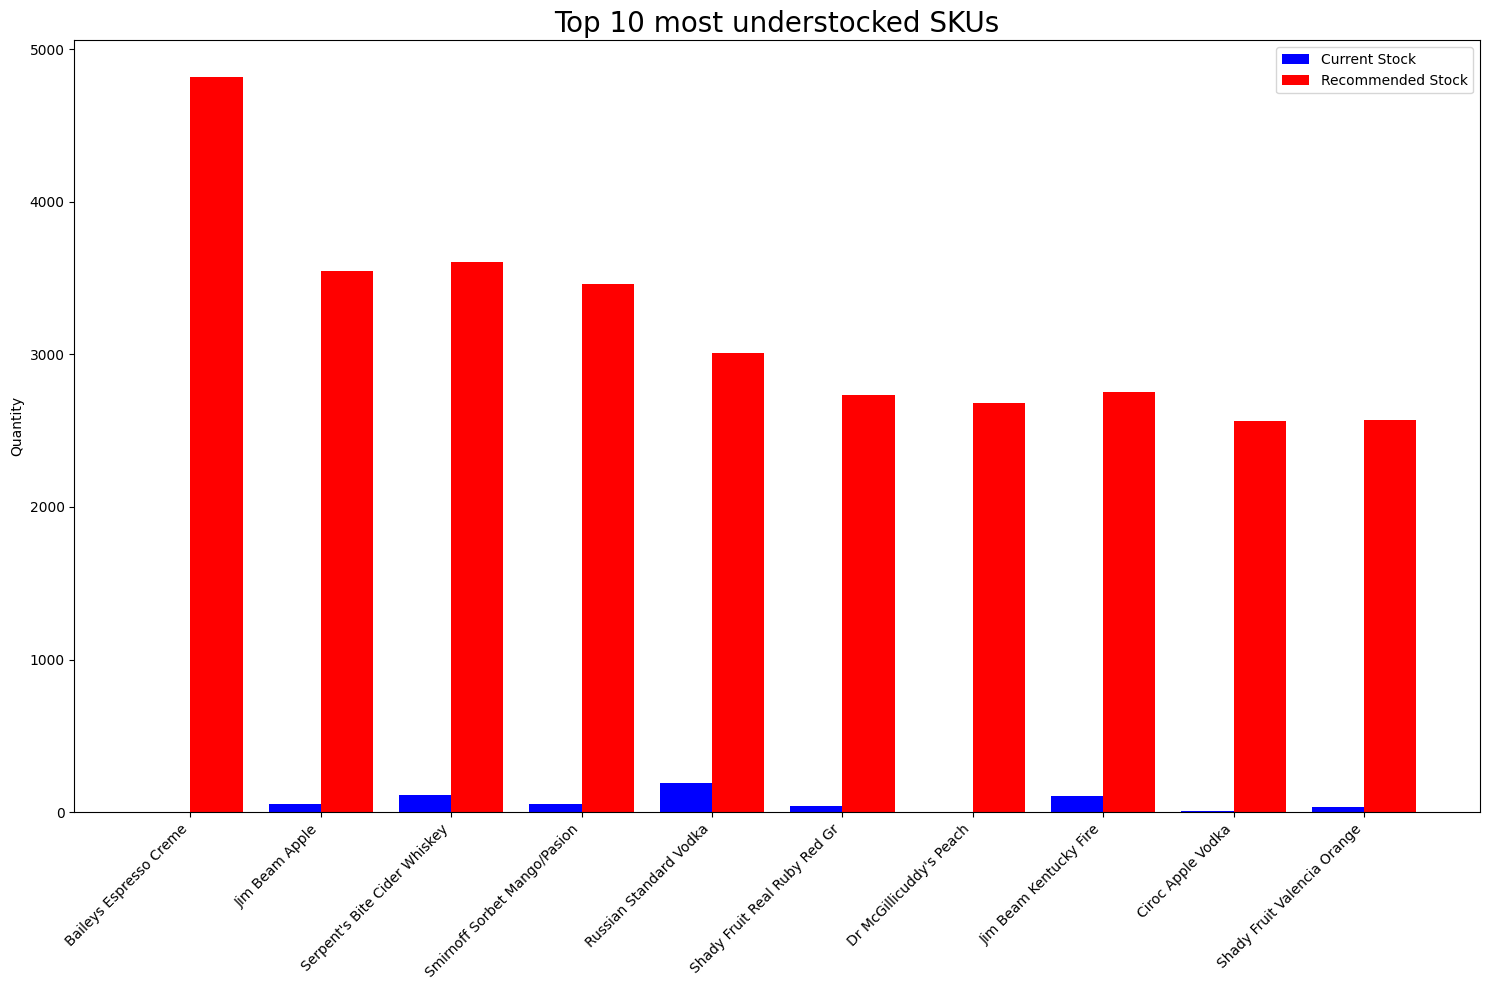

In [ ]:
top_10_to_order = needed_stock_df.sort_values('understock_quantity',ascending=False).head(10)
top_10_to_order = pd.merge(top_10_to_order,sales[['Brand','Description']].drop_duplicates(),on='Brand',how='left')
bar_width = 0.4
index = np.arange(len(top_10_to_order))

plt.figure(figsize=(15, 10))
bar1 = plt.bar(index, top_10_to_order['current_stock'], bar_width, label='Current Stock', color='b')
bar2 = plt.bar([i + bar_width for i in index], top_10_to_order['rec_stock'], bar_width, label='Recommended Stock', color='r')
plt.ylabel('Quantity')
plt.title('Top 10 most understocked SKUs',fontsize=20)
plt.xticks([i + bar_width / 2 for i in index], top_10_to_order['Description'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Display items never sold but held in inventory. These SKUs don't necessarily need to be immediately thrown out, but should be investigated more thoroughly.

In [ ]:
needed_stock_df.loc[(needed_stock_df.current_stock > 0) & (needed_stock_df.Quantity==0)].sort_values('current_stock',ascending=False)

,Brand,total_value,Quantity,avg_price,avg_paid,avg_markup,avg_profit,current_stock,abc_class,xyz_class,...,sales_std,lead_time_mean,lead_time_std,safety_stock,EOQ,rec_stock,understock_quantity,overstock_quantity,is_understocked,is_overstocked
9830,3581,0.0,0.0,0.99,NaN,NaN,NaN,10493.0,C,Z,...,NaN,7.160255,1.739468,NaN,NaN,NaN,NaN,NaN,False,True
9832,3594,0.0,0.0,0.99,NaN,NaN,NaN,9646.0,C,Z,...,NaN,7.337199,1.873854,NaN,NaN,NaN,NaN,NaN,False,True
9853,3566,0.0,0.0,0.99,NaN,NaN,NaN,9514.0,C,Z,...,NaN,7.514444,1.783669,NaN,NaN,NaN,NaN,NaN,False,True
9679,3638,0.0,0.0,0.99,NaN,NaN,NaN,8921.0,C,Z,...,NaN,7.936169,1.990926,NaN,NaN,NaN,NaN,NaN,False,True
9460,3454,0.0,0.0,0.99,NaN,NaN,NaN,8876.0,C,Z,...,NaN,8.167662,1.992917,NaN,NaN,NaN,NaN,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8517,10991,0.0,0.0,12.99,NaN,NaN,NaN,1.0,C,Z,...,NaN,7.905660,2.347373,NaN,NaN,NaN,NaN,NaN,False,True
11370,3908,0.0,0.0,24.99,NaN,NaN,NaN,1.0,C,Z,...,NaN,7.000000,3.000000,NaN,NaN,NaN,NaN,NaN,False,True
11364,17444,0.0,0.0,7.99,NaN,NaN,NaN,1.0,C,Z,...,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,False,True
7713,1498,0.0,0.0,99.99,NaN,NaN,NaN,1.0,C,Z,...,NaN,5.777778,1.641470,NaN,NaN,NaN,NaN,NaN,False,True


Display proportion breakdown by class.

In [ ]:
df_by_abc = needed_stock_df.groupby('abc_class').agg(
    understock_quan = ('understock_quantity','sum'),
    overstock_quan = ('overstock_quantity','sum'),
    SKUs_understocked = ('is_understocked','sum'),
    SKUs = ('abc_class','count'),
    SKUs_overstocked = ('is_overstocked','sum')).reset_index()
df_by_abc['perc_understock_quan'] = df_by_abc.understock_quan.div(df_by_abc.understock_quan.sum()).round(2)
df_by_abc['perc_understocked'] = df_by_abc.SKUs_understocked.div(df_by_abc.SKUs).round(2)
df_by_abc['perc_overstock_quan'] = df_by_abc.overstock_quan.div(df_by_abc.overstock_quan.sum()).round(2)
df_by_abc['perc_overstocked'] = df_by_abc.SKUs_overstocked.div(df_by_abc.SKUs).round(2)
df_by_abc.drop('SKUs',axis=1)

,abc_class,understock_quan,overstock_quan,SKUs_understocked,SKUs_overstocked,perc_understock_quan,perc_understocked,perc_overstock_quan,perc_overstocked
0,A,43820.0,1915076.0,104,1396,0.15,0.07,0.71,0.91
1,B,85724.0,555641.0,294,1435,0.30,0.16,0.20,0.78
2,C,155259.0,242161.0,1658,4862,0.55,0.20,0.09,0.60


In [ ]:
df_by_xyz = needed_stock_df.groupby('xyz_class').agg(
    understock_quan = ('understock_quantity','sum'),
    overstock_quan = ('overstock_quantity','sum'),
    SKUs = ('xyz_class','count'),
    SKUs_understocked = ('is_understocked','sum'),
    SKUs_overstocked = ('is_overstocked','sum')).reset_index()
df_by_xyz['perc_understock_quan'] = df_by_xyz.understock_quan.div(df_by_xyz.understock_quan.sum()).round(2)
df_by_xyz['perc_understocked'] = df_by_xyz.SKUs_understocked.div(df_by_xyz.SKUs).round(2)
df_by_xyz['perc_overstock_quan'] = df_by_xyz.overstock_quan.div(df_by_xyz.overstock_quan.sum()).round(2)
df_by_xyz['perc_overstocked'] = df_by_xyz.SKUs_overstocked.div(df_by_xyz.SKUs).round(2)
df_by_xyz.drop('SKUs',axis=1)

,xyz_class,understock_quan,overstock_quan,SKUs_understocked,SKUs_overstocked,perc_understock_quan,perc_understocked,perc_overstock_quan,perc_overstocked
0,X,129606.0,2197105.0,287,2167,0.46,0.11,0.81,0.85
1,Y,105346.0,440784.0,784,1573,0.37,0.31,0.16,0.62
2,Z,49851.0,74989.0,985,3953,0.18,0.15,0.03,0.62


In [ ]:
df_by_abc_xyz = needed_stock_df.groupby('abc_xyz_class').agg(
    understock_quan = ('understock_quantity','sum'),
    overstock_quan = ('overstock_quantity','sum'),
    SKUs = ('abc_xyz_class','count'),
    SKUs_understocked = ('is_understocked','sum'),
    SKUs_overstocked = ('is_overstocked','sum')).reset_index()
df_by_abc_xyz['perc_understock_quan'] = df_by_abc_xyz.understock_quan.div(df_by_abc_xyz.understock_quan.sum()).round(2)
df_by_abc_xyz['perc_understocked'] = df_by_abc_xyz.SKUs_understocked.div(df_by_abc_xyz.SKUs).round(2)
df_by_abc_xyz['perc_overstock_quan'] = df_by_abc_xyz.overstock_quan.div(df_by_abc_xyz.overstock_quan.sum()).round(2)
df_by_abc_xyz['perc_overstocked'] = df_by_abc_xyz.SKUs_overstocked.div(df_by_abc_xyz.SKUs).round(2)
df_by_abc_xyz.drop('SKUs',axis=1)

,abc_xyz_class,understock_quan,overstock_quan,SKUs_understocked,SKUs_overstocked,perc_understock_quan,perc_understocked,perc_overstock_quan,perc_overstocked
0,AX,35675.0,1763445.0,72,1249,0.13,0.05,0.65,0.93
1,AY,7398.0,150055.0,28,141,0.03,0.16,0.06,0.82
2,AZ,747.0,1576.0,4,6,0.00,0.29,0.00,0.43
3,BX,52667.0,392227.0,140,816,0.18,0.14,0.14,0.80
4,BY,31228.0,156554.0,130,555,0.11,0.18,0.06,0.77
5,BZ,1829.0,6860.0,24,64,0.01,0.25,0.00,0.66
6,CX,41264.0,41433.0,75,102,0.14,0.39,0.02,0.54
7,CY,66720.0,134175.0,626,877,0.23,0.38,0.05,0.53
8,CZ,47275.0,66553.0,957,3883,0.17,0.15,0.02,0.62


Observations: Every class suffers from severe overstocking, A and X class most of all. Many also have significant understocking, particularly the C and Y classes, although they aren't as much of a priority. This suggests that the company has overbet on its consistent winners, underestimating the cost of overstocking them, while underbetting on its less shiny SKUs, underestimating the cost of being out of stock.

In [ ]:
total_stock = df_by_class.current_stock.sum()
total_understock = df_by_abc_xyz.understock_quan.sum()
total_overstock = df_by_abc_xyz.overstock_quan.sum()
rec_total_stock = total_stock+total_understock-total_overstock
stock_reduction = 1-rec_total_stock/total_stock
print(f'Total stock: {total_stock:,.0f}')
print(f'Total understock: {total_understock:,.0f}')
print(f'Total overstock: {total_overstock:,.0f}')
print(f'Recommended total stock: {rec_total_stock:,.0f}')
print(f'Possible stock reduction: {round(stock_reduction*100,1)}%')

Total stock: 4,885,776
Total understock: 284,803
Total overstock: 2,712,878
Recommended total stock: 2,457,701
Possible stock reduction: 49.7%
